In [39]:
!pip install hpelm
!pip install imbalanced-learn

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from hpelm import ELM
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


In [41]:
data = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/cic-collection.parquet')

In [42]:
data.head()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Mean,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,ClassLabel
0,4,2,0,12.0,0.0,6.0,6.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,Benign
1,1,2,0,12.0,0.0,6.0,6.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,Benign
2,3,2,0,12.0,0.0,6.0,6.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,Benign
3,1,2,0,12.0,0.0,6.0,6.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,Benign
4,609,7,4,484.0,414.0,233.0,69.14286,111.967896,207.0,103.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,Benign


In [43]:
# Downsample the dataset to 10,000 rows for initial testing
data = data.sample(n=50000, random_state=0)

In [44]:
data.loc[data['ClassLabel'] != 'Benign', 'ClassLabel'] = 1
data.loc[data['ClassLabel'] == 'Benign', 'ClassLabel'] = 0
data['ClassLabel'] = data['ClassLabel'].astype(dtype=np.int32)

In [45]:
data.head(20)

,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Mean,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,ClassLabel
2288900,115512291,16,14,445.0,706.0,434.0,27.812500,108.317566,706.0,50.428570,...,18886.273438,2.410101e+04,91551.0,11454.0,9999225.0,15339.338867,10004051.0,9952979.0,Benign,0
7591644,31261,2,2,80.0,112.0,40.0,40.000000,0.000000,56.0,56.000000,...,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,Benign,0
1647805,63211,2,2,92.0,214.0,46.0,46.000000,0.000000,107.0,107.000000,...,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,Benign,0
684517,112639654,3,0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000e+00,0.0,0.0,56300000.0,48.083260,56300000.0,56300000.0,Benign,0
2061481,2235306,8,7,1148.0,1581.0,677.0,143.500000,228.129669,1173.0,225.857147,...,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,Benign,0
1054516,6608,2,0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,Benign,0
6347243,1405743,8,7,1132.0,1581.0,661.0,141.500000,222.792023,1173.0,225.857147,...,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,Benign,0
1498555,115265793,19,16,1488.0,845.0,497.0,78.315788,184.193146,282.0,52.812500,...,473620.375000,1.520556e+06,5058270.0,15010.0,10000000.0,18191.710938,10000000.0,9953580.0,Benign,0
3813891,25340,2,0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,DDoS-HOIC,1
9140672,263,2,2,58.0,506.0,29.0,29.000000,0.000000,253.0,253.000000,...,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,Benign,0


In [46]:
data.columns

Index(['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
       'Fwd Packets Length Total', 'Bwd Packets Length Total',
       'Fwd Packet Length Max', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'SYN Flag Count',
       'URG Flag Count', 'Avg Packet Size', 'Avg Fwd Segment Size',
       'Avg Bwd Segment Size', 'Subflow Fwd Packets', 'Subflow Fwd Bytes',
       'Subflow Bwd Packets', 'Subflow Bwd By

In [47]:
data['ClassLabel'].value_counts()

,count
ClassLabel,
0,39385
1,10615


In [48]:
# Separate the data into two DataFrames based on class label
df_class_0 = data[data['ClassLabel'] == 0]
df_class_1 = data[data['ClassLabel'] == 1]

# Randomly sample 6387 rows from each DataFrame
df_class_0_sampled = df_class_0.sample(n=10000, random_state=0)
df_class_1_sampled = df_class_1.sample(n=10000, random_state=0)

# Concatenate the sampled DataFrames to create the balanced dataset
balanced_data = pd.concat([df_class_0_sampled, df_class_1_sampled])

# Shuffle the balanced dataset
data = balanced_data.sample(frac=1, random_state=0)

# Now you can use 'balanced_data' for further analysis

In [49]:
data

,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Mean,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,ClassLabel
1449688,8937466,9,15,106.0,188.0,28.0,11.777778,9.871395,34.0,12.533334,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,Bruteforce-FTP,1
2343725,1630533,8,7,1128.0,1581.0,661.0,141.000000,222.623322,1173.0,225.857147,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,Benign,0
6084560,4067380,4,5,358.0,935.0,358.0,89.500000,179.000000,935.0,187.000000,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,DoS-Hulk,1
3286205,32381626,2,0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.00000,0.0,0.0,32400000.0,0.0,32400000.0,32400000.0,DDoS-LOIC-HTTP,1
8697843,5376703,4,4,97.0,231.0,97.0,24.250000,48.500000,231.0,57.750000,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,Benign,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3301128,25274310,2,0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.00000,0.0,0.0,25300000.0,0.0,25300000.0,25300000.0,DDoS-LOIC-HTTP,1
3246427,732555,3,4,20.0,964.0,20.0,6.666667,11.547006,964.0,241.000000,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,DDoS-LOIC-HTTP,1
1685933,181,2,2,104.0,136.0,52.0,52.000000,0.000000,68.0,68.000000,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,Benign,0
6631385,7002936,10,13,1392.0,2811.0,677.0,139.199997,204.801147,1173.0,216.230774,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,Infiltration,1


In [50]:
data['ClassLabel'].value_counts()

,count
ClassLabel,
1,10000
0,10000


In [51]:
#droppinng the lable column since it has been encoded in to 0 and 1 in the class label column with 0 being bengin and others is 1
data.drop(columns=['Label'], inplace=True)
#To help with feature selection, we are calculating the correlation score of the features.
# Convert all columns except 'ClassLabel' to numeric, errors='coerce' replaces non-numeric values with NaN
numeric_data = data.drop(columns=['ClassLabel']).apply(pd.to_numeric, errors='coerce')

# Concatenate the numeric data with the 'ClassLabel' column
data_numeric = pd.concat([numeric_data, data['ClassLabel']], axis=1)

In [52]:
#To help with feature selection, we are calculating the correlation score of the features.
data_new = data_numeric.corrwith(data['ClassLabel']).abs().sort_values(ascending=False)

In [53]:
data_new

,0
ClassLabel,1.000000
Init Bwd Win Bytes,0.301574
Avg Packet Size,0.228198
Packet Length Mean,0.225220
Bwd Packet Length Std,0.222773
Bwd Packet Length Max,0.198845
Packet Length Max,0.193411
Packet Length Variance,0.190191
Packet Length Std,0.183518
Fwd Packet Length Std,0.177127


In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

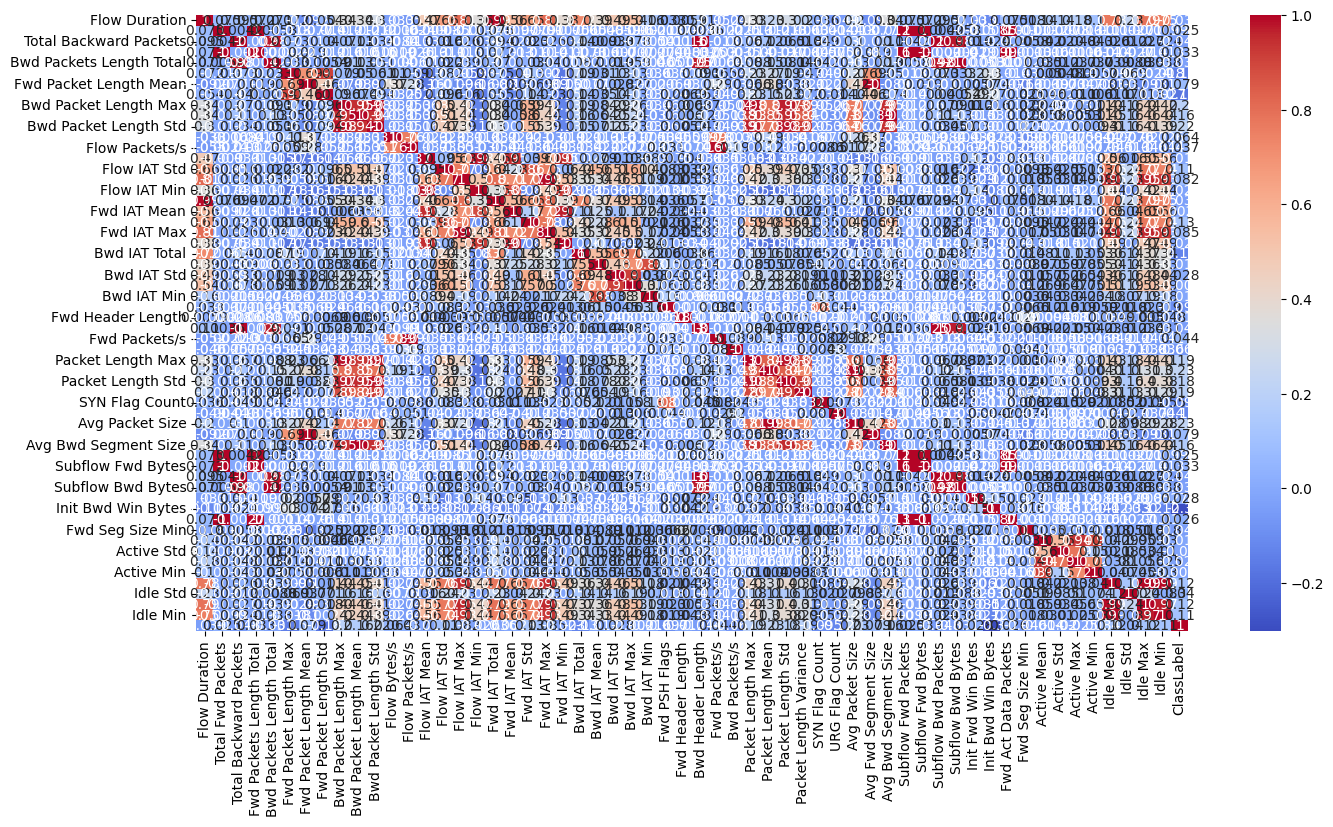

In [55]:
plt.figure(figsize=(16, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()

In [56]:
# prompt: i want to drop colums whose correlation score is less than 0.04

# Drop columns with correlation score less than 0.04
columns_to_drop = data_new[data_new < 0.04].index
data = data.drop(columns=columns_to_drop)


In [57]:
data.head()

,Total Backward Packets,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow IAT Std,Flow IAT Max,...,Avg Fwd Segment Size,Avg Bwd Segment Size,Subflow Bwd Packets,Init Bwd Win Bytes,Fwd Seg Size Min,Idle Mean,Idle Std,Idle Max,Idle Min,ClassLabel
1449688,15,28.0,11.777778,9.871395,34.0,12.533334,14.549750,32.895230,1.014773e+06,3264732.0,...,11.777778,12.533334,15,227,32,0.0,0.0,0.0,0.0,1
2343725,7,661.0,141.000000,222.623322,1173.0,225.857147,430.098602,1661.419916,2.414544e+05,937537.0,...,141.000000,225.857147,7,62872,20,0.0,0.0,0.0,0.0,0
6084560,5,358.0,89.500000,179.000000,935.0,187.000000,418.144714,317.895050,1.424509e+06,4033812.0,...,89.500000,187.000000,5,237,32,0.0,0.0,0.0,0.0,1
3286205,0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,32400000.0,...,0.000000,0.000000,0,-1,20,32400000.0,0.0,32400000.0,32400000.0,1
8697843,4,97.0,24.250000,48.500000,231.0,57.750000,115.500000,61.003927,2.004934e+06,5314568.0,...,24.250000,57.750000,4,141,20,0.0,0.0,0.0,0.0,0


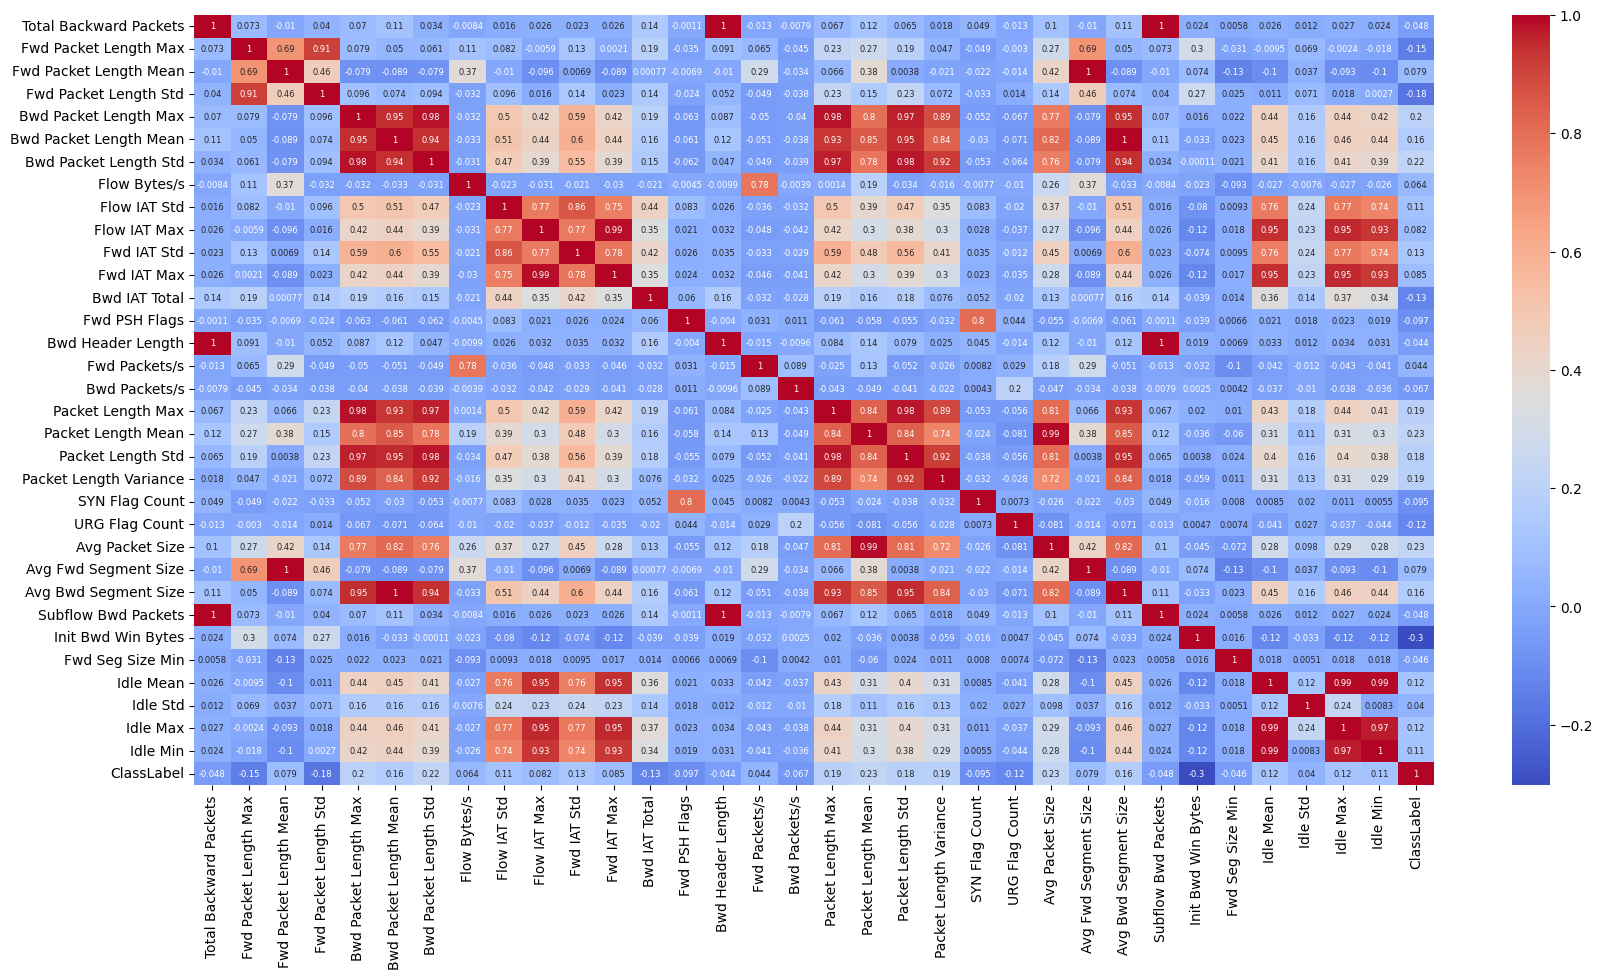

In [58]:
plt.figure(figsize=(20, 10))
sns.heatmap(data.corr(), annot=True, annot_kws={'size': 6}, cmap='coolwarm')
#sns.set(font_scale = 1.4)
#for saving the figure
#plt.savefig(correlation.png, dpi=1200)
plt.show()

In [59]:
data.isnull().sum()

,0
Total Backward Packets,0
Fwd Packet Length Max,0
Fwd Packet Length Mean,0
Fwd Packet Length Std,0
Bwd Packet Length Max,0
Bwd Packet Length Mean,0
Bwd Packet Length Std,0
Flow Bytes/s,0
Flow IAT Std,0
Flow IAT Max,0


In [60]:
x = data.drop(columns=['ClassLabel'])
y = data['ClassLabel']

In [61]:
from sklearn.preprocessing import StandardScaler

In [62]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [63]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [64]:
def train_and_evaluate_elm(X_train, X_test, y_train, y_test, nh=100, activation_func='sigm'):
    # Initialize ELM
    elm = ELM(X_train.shape[1], 1)  # Input size, output size (1 for binary classification)
    elm.add_neurons(nh, activation_func)  # Add hidden neurons with the specified activation function

    # Train ELM
    elm.train(X_train, y_train.to_numpy())  # Convert y_train to NumPy array

    # Predict
    y_pred = elm.predict(X_test)
    y_pred = np.round(y_pred >= 0.5).astype(int)  # Convert probabilities to binary predictions

    # Evaluation
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')
    #print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
    print('Classification Report:\n', classification_report(y_test, y_pred))
    #print('AUC-ROC:', roc_auc_score(y_test, y_pred))



    cm = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix:')
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
   #print(cm)

    return elm

In [68]:
# Define the parameter grid
param_grid = {
    'nh': [50, 100, 150, 200],  # Number of hidden neurons
    'activation_func': ['sigm', 'tanh', 'rbf_l2']  # Activation functions
}

# Create an ELM object
#base_elm = ELM(X_train.shape[1], 1)

# Create a GridSearchCV object
# Use a BaseEstimator to wrap ELM for compatibility with GridSearchCV


class ELMWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, nh=100, activation_func='sigm'):
        self.nh = nh
        self.activation_func = activation_func
        #self.elm = ELM(X_train.shape[1], 1) # Moved ELM initialization to fit

    def fit(self, X, y):
        self.elm = ELM(X.shape[1], 1) # Initialize ELM here
        self.elm.add_neurons(self.nh, self.activation_func)
        self.elm.train(X, y.to_numpy())
        return self

    def predict(self, X):
        y_pred = self.elm.predict(X)
        return np.round(y_pred >= 0.5).astype(int)

# Create an instance of the ELMWrapper
base_elm = ELMWrapper()

grid_search = GridSearchCV(
    estimator=base_elm,
    param_grid=param_grid,
    scoring='accuracy',  # Use accuracy as the evaluation metric
    cv=5,  # 5-fold cross-validation
    n_jobs=1, # Changed n_jobs to 1 to avoid pickling issues.
    verbose=2 # Use all available CPU cores
)


grid_search.fit(X_train, y_train) # Fit directly now

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the model with the best hyperparameters
best_elm = grid_search.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ........................activation_func=sigm, nh=50; total time=   0.7s
[CV] END ........................activation_func=sigm, nh=50; total time=   0.4s
[CV] END ........................activation_func=sigm, nh=50; total time=   0.5s
[CV] END ........................activation_func=sigm, nh=50; total time=   0.4s
[CV] END ........................activation_func=sigm, nh=50; total time=   0.4s
[CV] END .......................activation_func=sigm, nh=100; total time=   0.5s
[CV] END .......................activation_func=sigm, nh=100; total time=   0.6s
[CV] END .......................activation_func=sigm, nh=100; total time=   0.6s
[CV] END .......................activation_func=sigm, nh=100; total time=   0.8s
[CV] END .......................activation_func=sigm, nh=100; total time=   0.4s
[CV] END .......................activation_func=sigm, nh=150; total time=   0.6s
[CV] END .......................activation_func=

Accuracy: 0.9303
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      1989
           1       0.93      0.93      0.93      2011

    accuracy                           0.93      4000
   macro avg       0.93      0.93      0.93      4000
weighted avg       0.93      0.93      0.93      4000

Confusion Matrix:


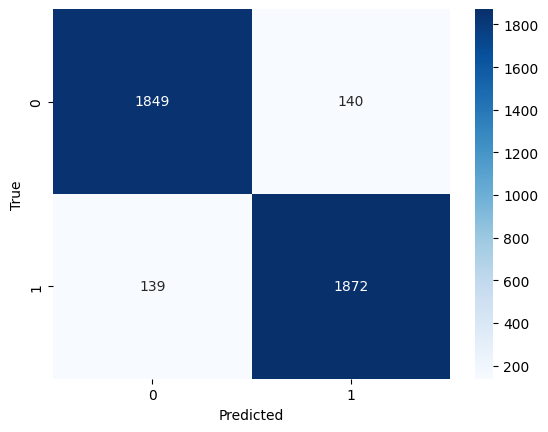

In [69]:
train_and_evaluate_elm(X_train, X_test, y_train, y_test,
                       nh=best_elm.nh, activation_func=best_elm.activation_func)

In [66]:
#train_and_evaluate_elm(X_train, X_test, y_train, y_test)